## Minst Data Set

### Pytouch CNN

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import time
import torch
import torch.nn as nn
import torch.utils.data as Data
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from sklearn.metrics import accuracy_score, confusion_matrix

In [3]:
print('torch version: ', torch.__version__)

torch version:  2.4.1+cpu


In [4]:
# 模型加载选择GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.device_count())
# print(torch.cuda.get_device_name(0))

cpu
0


In [5]:
# 准备训练数据集
train_data = FashionMNIST(
    root="./FashionMNIST",            # 数据的路径
    train=True,                       # 只使用训练数据集
    transform=transforms.ToTensor(),  # 用于对载入的图片数据进行类型转换，将之前构成 PIL 图片的数据转换成 Tensor 数据类型的变量，让 PyTorch 能够对其进行计算和处理。
    download=True
)

# 准备测试数据集
test_data = FashionMNIST(
    root="./FashionMNIST",            # 数据的路径
    train=False,                      # 只使用训练数据集
    download=True
)

# 定义一个数据加载器
train_loader = Data.DataLoader(
    dataset=train_data,              # 使用的数据集
    batch_size=64,                   # 批处理样本大小
    shuffle=False,                   # 每次迭代前不打乱数据
    num_workers=2,                 # 使用两个进程
)

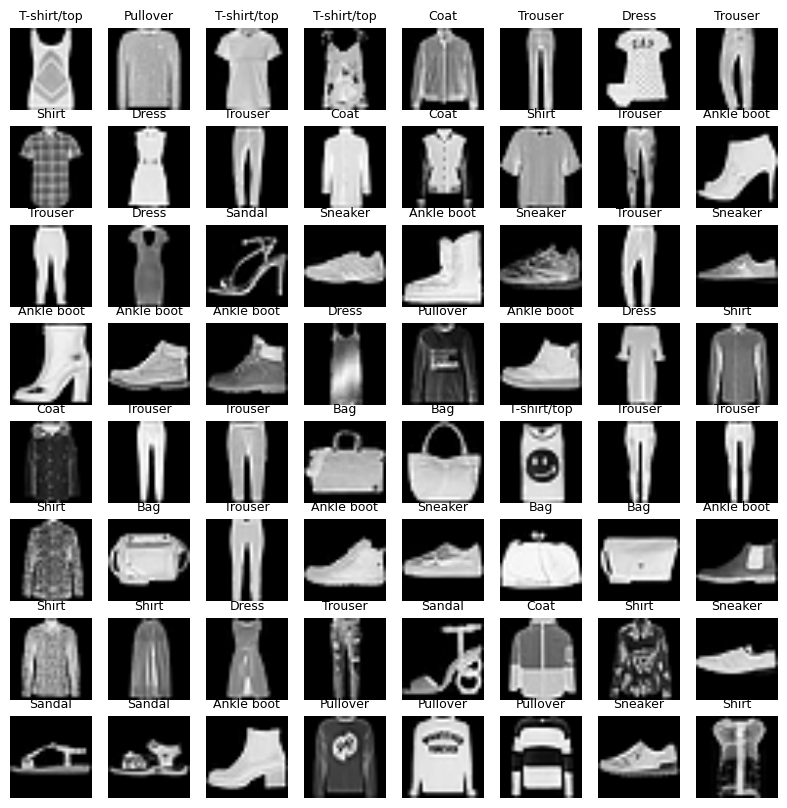

In [6]:
# 获取一个batch的数据
for step, (b_x, b_y) in enumerate(train_loader):
    if step > 0:
        break

# 一个batch里的图片可视化
batch_x = b_x.squeeze().numpy()
batch_y = b_y.numpy()
class_label = train_data.classes
plt.figure(figsize=(10, 10))
for ii in np.arange(len(batch_y)):
    plt.subplot(8, 8, ii+1)
    plt.imshow(batch_x[ii, :, :], cmap=plt.cm.gray,interpolation='bilinear')
    plt.title(class_label[batch_y[ii]], size=9)
    plt.axis("off")
    plt.subplots_adjust(wspace=0.1)
plt.show()

# 测试集数据预处理
test_data_x = test_data.data.type(torch.FloatTensor)/255.0
test_data_x = torch.unsqueeze(test_data_x, dim=1)  # [10000, 1, 28, 28]
test_data_y = test_data.targets  # 测试集的标签 [10000]

In [10]:
test_data_y.unique()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

### LeNet

In [19]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, 5), # in_channels, out_channels, kernel_size
            nn.Sigmoid(),
            nn.MaxPool2d(2, 2), # kernel_size, stride
            nn.Conv2d(16, 32, 5),
            nn.Sigmoid(),
            nn.MaxPool2d(2, 2)
        )
        self.fc = nn.Sequential(
            nn.Linear(32*4*4, 120),
            nn.Sigmoid(),
            nn.Linear(120, 84),
            nn.Sigmoid(),
            nn.Linear(84, 10)
        )

    def forward(self, img):
        feature = self.conv(img)
        output = self.fc(feature.view(img.shape[0], -1))
        return output


### CNN

In [31]:
# 定义网络结构
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # 定义第一个卷积层
        self.conv1 = nn.Sequential(
            nn.Conv2d(1,16,kernel_size=3,stride=1,padding=1,),   #(1，28，28）---> (16，28，28）
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2,stride=2,),)              #（16,14,14）
        
        # 如果想要 con2d 出来的图片长宽没有变化, padding=(kernel_size-1)/2 当 stride=1

        # 定义第二个卷积层
        self.conv2 = nn.Sequential(
            nn.Conv2d(16,32 ,kernel_size=3,stride=1,padding=0,), # （16,14,14）---> (32,12,12）
            nn.BatchNorm2d(32),
            nn.ReLU(),  
            nn.AvgPool2d(kernel_size=2,stride=2,),               # （32,6,6）
        )

        # 定义第三个卷积层
        self.conv3 = nn.Sequential(
            nn.Conv2d(32,64,kernel_size=3,stride=1,padding=0,),  # （32,6 ,6 ）---> (32,4 ,4 ）
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2 ,stride=1,),              # （64,3,3）         
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 3 * 3, 256),
            nn.ReLU(),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )
    #  定义网络向前传播路径
    def forward(self, x):
        x = self.conv1(x)            # （batch_size,16,14,14）
        x = self.conv2(x)            # （batch_size,32,6,6）
        #x = F.dropout(x, p=0.2, training=self.training)  Drop out 防止过拟合
        x = self.conv3(x)            # （batch_size,64,6,6）
        x = x.view(x.size(0), -1)    #  (batch_size,64*6*6)
        output = self.classifier(x)  #  (batch_size,10)
        return output

### Resnet

In [37]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, use_1x1conv=True, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)  
        
        if use_1x1conv:
            self.conv3=nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)
        else:
            self.conv3=None
    
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.conv3:
            identity =self.conv3(x)
        out += identity
        out = self.relu(out)
        return out

# Define ResNet18
class resnet18(nn.Module):
    def __init__(self, num_classes=10):
        super(resnet18, self).__init__()
        self.in_channels = 16

        # Initial convolution layer
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Residual layer
        self.layer1 = self._make_layer(16, 2)
        self.layer2 = self._make_layer(32, 2, stride=2)
        self.layer3 = self._make_layer(64, 2, stride=2)
        self.layer4 = self._make_layer(128, 2, stride=2)

        # The average pool of dropout and the full connection layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(128, num_classes)

    def _make_layer(self, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(ResidualBlock(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)

        # 应用 Dropout
        x = self.dropout(x)

        x = self.fc(x)
        return x


In [38]:
myconvnet = resnet18()

In [39]:
# 定义网络训练过程函数
def train_model(model, traindataloader, train_rate, criterion, optimizer, num_epochs):
    
    batch_num = len(traindataloader)                   # 获取训练总batch数
    train_batch_num = round(batch_num * train_rate)    # 按照train_rate比例进行训练集的划分
    
    # 复制模型参数
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss_all = []
    train_acc_all = []
    val_loss_all = []
    val_acc_all = []
    since = time.time()
    
    # 训练轮次循环
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
 
        train_loss = 0.0
        train_corrects = 0
        train_num = 0
        val_loss = 0.0
        val_corrects = 0
        val_num = 0
 
        # 每个epoch有两个训练阶段
        for step, (b_x, b_y) in enumerate(traindataloader):
            if step < train_batch_num:         # 训练集
                model.train()                  # 设置模型为训练模式
                output = model(b_x)
                pre_lab = torch.argmax(output, 1)
                loss = criterion(output, b_y)  # 计算损失函数
                optimizer.zero_grad()          # 清空上一层梯度
                loss.backward()                # 反向传播
                optimizer.step()               # 更新优化器的学习率
                train_loss += loss.item() * b_x.size(0)
                train_corrects += torch.sum(pre_lab == b_y.data)
                train_num += b_x.size(0)
            else:
                model.eval()                   # 设置模型为评估模式
                output = model(b_x)
                pre_lab = torch.argmax(output, 1)
                loss = criterion(output, b_y)
                val_loss += loss.item() * b_x.size(0)
                val_corrects += torch.sum(pre_lab == b_y.data)
                val_num += b_x.size(0)
 
        # 计算一个epoch在训练集和验证集上的损失和精度
        train_loss_all.append(train_loss / train_num)
        train_acc_all.append(train_corrects.double().item()/train_num)
        val_loss_all.append(val_loss / val_num)
        val_acc_all.append(val_corrects.double().item()/val_num)
 
        print('{} Train Loss: {:.4f} Train Acc: {:.4f}'.format(epoch, train_loss_all[-1], 
train_acc_all[-1]))
 
        print('{} Val Loss: {:.4f} Val Acc: {:.4f}'.format(epoch, val_loss_all[-1], val_acc_all[-1]))
 
        # 当精度创新高，复制模型最高精度下的参数
        if val_acc_all[-1] > best_acc:
            best_acc = val_acc_all[-1]
            best_model_wts = copy.deepcopy(model.state_dict())
        time_use = time.time() - since
        print("Train and val complete in {:.0f}m {:.0f}s".format(time_use // 60, time_use % 60))
 
        # 使用最好模型的参数
    model.load_state_dict(best_model_wts)
    train_process = pd.DataFrame(
        data={"epoch": range(num_epochs),
              "train_loss_all":train_loss_all,
              "val_loss_all":val_loss_all,
              "train_acc_all": train_acc_all,
              "val_acc_all": val_acc_all,
              }
    )
    return model, train_process

In [ ]:
# 对模型进行训练
optimizer = torch.optim.Adam(myconvnet.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()  # 损失函数
myconvnet, train_process = train_model(myconvnet, train_loader, 0.8, criterion, optimizer, num_epochs=25)
 
# 对测试集进行预测，并可视化预测效果
myconvnet.eval()
output = myconvnet(test_data_x)
pre_lab = torch.argmax(output, 1)
acc = accuracy_score(test_data_y, pre_lab)

Epoch 0/24
0 Train Loss: 0.6584 Train Acc: 0.7597
0 Val Loss: 0.4864 Val Acc: 0.8339
Train and val complete in 0m 48s
Epoch 1/24
1 Train Loss: 0.4388 Train Acc: 0.8448
1 Val Loss: 0.4040 Val Acc: 0.8530
Train and val complete in 1m 38s
Epoch 2/24
2 Train Loss: 0.3903 Train Acc: 0.8615
2 Val Loss: 0.4040 Val Acc: 0.8548
Train and val complete in 2m 32s
Epoch 3/24
3 Train Loss: 0.3622 Train Acc: 0.8701
3 Val Loss: 0.3529 Val Acc: 0.8690
Train and val complete in 3m 25s
Epoch 4/24
4 Train Loss: 0.3452 Train Acc: 0.8785
4 Val Loss: 0.3521 Val Acc: 0.8738
Train and val complete in 4m 19s
Epoch 5/24
5 Train Loss: 0.3330 Train Acc: 0.8836
5 Val Loss: 0.4096 Val Acc: 0.8619
Train and val complete in 5m 12s
Epoch 6/24
6 Train Loss: 0.3154 Train Acc: 0.8894
6 Val Loss: 0.4881 Val Acc: 0.8549
Train and val complete in 6m 8s
Epoch 7/24
7 Train Loss: 0.3156 Train Acc: 0.8912
7 Val Loss: 0.3517 Val Acc: 0.8784
Train and val complete in 7m 3s
Epoch 8/24
8 Train Loss: 0.3008 Train Acc: 0.8930
8 Val Lo

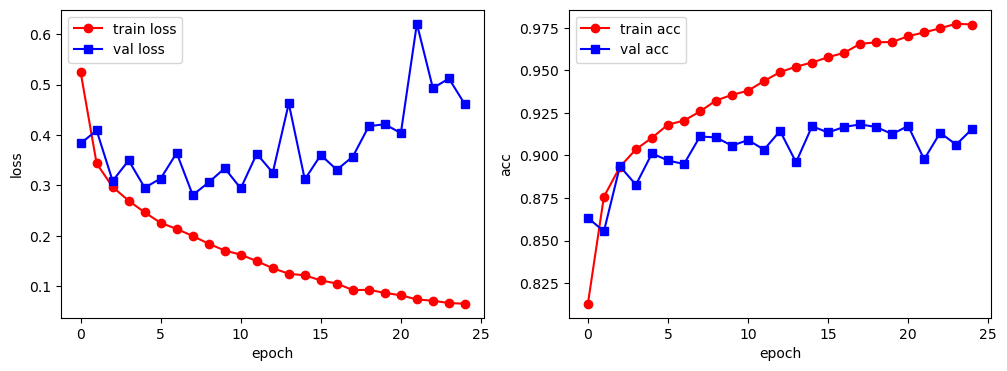

Text(95.72222222222221, 0.5, 'Predicted label')

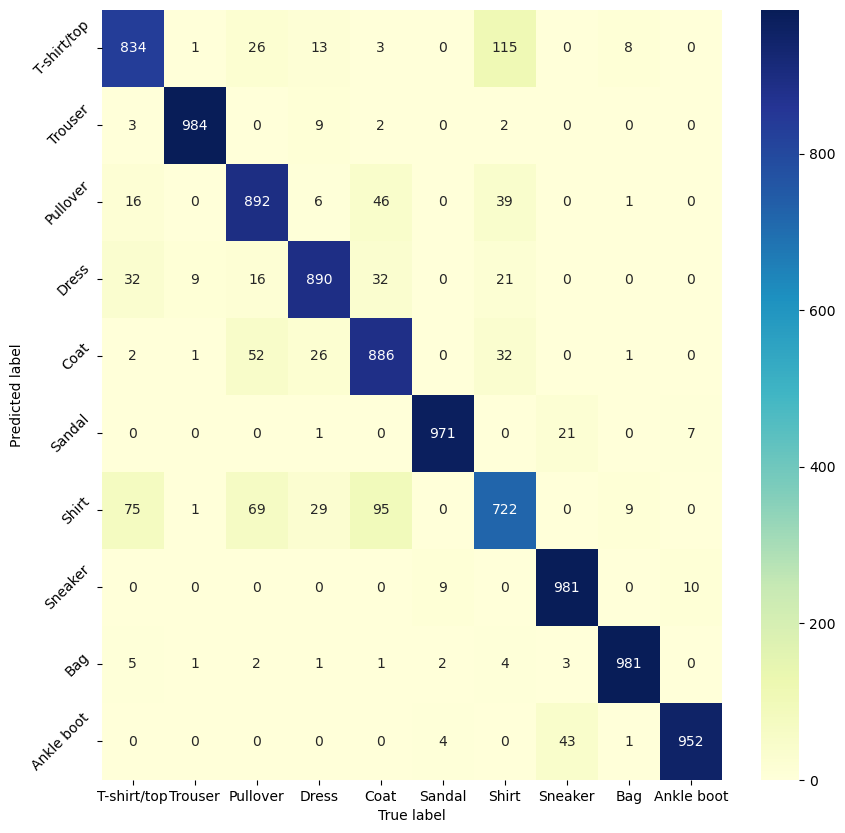

In [18]:
# 训练结果可视化
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_process.epoch, train_process.train_loss_all, "ro-", label="train loss")
plt.plot(train_process.epoch, train_process.val_loss_all, "bs-", label="val loss")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
 
plt.subplot(1, 2, 2)
plt.plot(train_process.epoch, train_process.train_acc_all, "ro-", label="train acc")
plt.plot(train_process.epoch, train_process.val_acc_all, "bs-", label="val acc")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("acc")
plt.show()
 
# 计算混淆矩阵可视化
con_mat = confusion_matrix(test_data_y, pre_lab)
con_mat_df = pd.DataFrame(con_mat, index=class_label, columns=class_label)
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(con_mat_df, annot=True, fmt="d", cmap="YlGnBu")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.set_ticklabels(class_label), rotation=0, ha='right')
heatmap.yaxis.set_ticklabels(heatmap.xaxis.set_ticklabels(class_label), rotation=45, ha='right')
plt.xlabel("True label")
plt.ylabel("Predicted label")